# 2　線形回帰モデル
このノートでは、教師あり学習、特に回帰問題の手法のなかで最も基本的な**線形回帰モデル**(linear regression)について説明します。

線形回帰モデルは、入力と出力との関係が1次式によっておおよそ表現可能な場合に有効なモデルで、**2乗損失**と呼ばれる損失を最小化するような1次式を予測器として学習することを説明します。また、線形回帰モデルの学習は
* 外れ値の影響を強く受ける。
* 多重共線性に注意する必要がある。

という注意点があげられることを説明し、特に多重共線性に対して有効な**正則化**という手法を紹介します。

In [1]:
# 以下で必要なモジュールをimportしておきましょう。
# anacomda prompt→ pip install yellowbrick
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.linear_model import LassoCV, RidgeCV
from yellowbrick.regressor import AlphaSelection
from sklearn.preprocessing import StandardScaler

## A　線形回帰モデル
**線形回帰モデル(linear regression)**について紹介しましょう。線形回帰モデルは、入力と出力が次のようにおおよそ1次式の関係で表現されるときに用いられるモデルです。

In [2]:
# ダミーデータの生成
X_train = np.linspace(start = -1.0, stop = 1.0, num = 50)
y_train = 1.0 + 2.0*X_train + np.random.normal(loc = 0.0, scale = 1.0, size = 50)

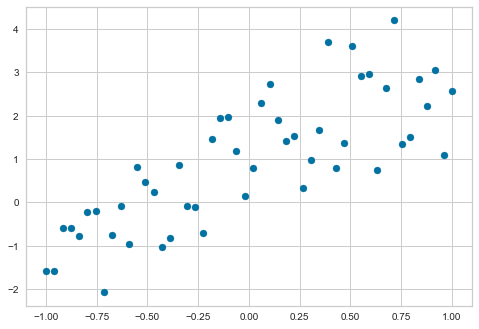

In [3]:
# データの可視化
plt.scatter(X_train, y_train)
plt.show()

#### A1. 仮説・損失関数
* 仮説：入力変数による1次式
$$y = f(x;w)=w_0+w_1x_1+\cdots+w_dx_d+誤差$$
* 損失関数：2乗損失
$$L(w)=(y-f(x;w))^2$$

学習時には、各データポイントに対して2乗損失を計算し、その平均値（**平均2乗損失**）
$$J(w) = \frac{1}{n}\sum_{i=1}^{n}(y_i-f(x_i;w))^2$$
が最も小さくなるような1次式の仮説$f(x;w)=w_0+w_1x_1+\cdots+w_dx_d$を予測器として求めます。

**演習** 次のようなデータポイントに対して、
* model A：$f(x) = 1 + 2x$
* model B：$g(x) = 3x$

を考えます。どちらのほうが平均2乗損失が低いかを計算してください。

In [4]:
# 演習のためのデータ
pd.DataFrame([[0, 0], [1, 3], [2, 4]], columns = ["X", "y"])

,X,y
0,0,0
1,1,3
2,2,4


$$J(1,2) = \frac{(0-f(0))^2 + (3-f(1))^2 + (4-f(2))^2)}{3}$$

$$J(0,3) = \frac{(0-g(0))^2 + (3-g(1))^2 + (4-g(2))^2)}{3}$$

In [5]:
data = pd.DataFrame([[0, 0], [1, 3], [2, 4]], columns = ["X", "y"])

print("modelAの平均2乗損失", np.sum((data.y-1-2*data.X)**2)/len(data))
print("modelBの平均2乗損失", np.sum((data.y-3*data.X)**2)/len(data))

modelAの平均2乗損失 0.6666666666666666
modelBの平均2乗損失 1.3333333333333333


#### A2. LinearRegressionのsklearnによる実装
#### 前準備
まずは前準備として、sklearnのために入力Xを2次元配列, 出力yを1次元配列で準備しておきましょう。（注意：先ほど入力を準備したとき、1次元配列になっていたためです。）

In [6]:
# 前準備：sklearnのために入力Xを2次元配列, 出力yを1次元配列で準備する。
X_train = X_train.reshape(50, 1)    # X_train.shape : (50,) -> (50, 1)

#### 学習と予測
では、実際に入力$X$と出力$y$のデータから線形回帰モデルを学習させてみましょう。線形回帰モデルは`LinearRegression`というクラス名で`sklearn.linear_model`モジュールに含まれています。
* trainメソッド：学習
* predictメソッド：予測

In [7]:
# LinearRegressionのインスタンスを建てて、学習させる。
LR = LinearRegression()    # インスタンスを建てる。
LR.fit(X_train, y_train)    # fitメソッド：学習させる。

LinearRegression()

In [8]:
# y = 2.652x + 1.14が平均二乗損失が小さいと学習している
print(LR.intercept_,LR.coef_)

0.9630985787973501 [2.01084126]


In [9]:
# テストデータの入力を生成し、実際に予測させる。
X_test = np.linspace(start = -1.0, stop = 1.0, num = 10000).reshape(10000, 1)
y_pred = LR.predict(X_test)    # predictメソッド：予測させる。
y_pred

array([-1.04774268, -1.04734047, -1.04693826, ...,  2.97313542,
        2.97353763,  2.97393983])

In [10]:
LR.coef_[0]*X_test[0]+LR.intercept_

array([-1.04774268])

#### 結果の確認
折角なので学習した結果を、入力をx軸に出力をy軸にとった散布図上に描いてみましょう。

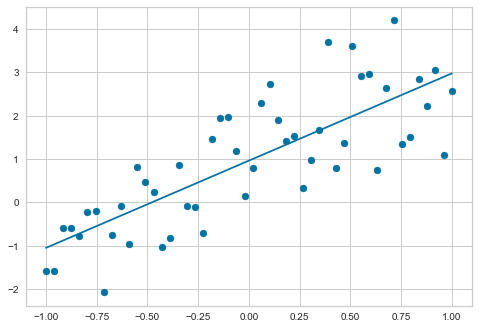

In [11]:
# 予測結果（1次式による直線）を散布図上に描いて確認する。
plt.scatter(X_train, y_train)
plt.plot(X_test.reshape(10000), y_pred)
plt.show()

また、学習によって得た予測式$f(x;w)=w_0+w_1x_1$のパラメータ$w_0,w_1$をそれぞれ**切片**、**回帰係数**といいます。これらは次のインスタンス変数で確認できます。
* intercept_：切片
* coef_:回帰係数

In [12]:
LR.intercept_, LR.coef_

(0.9630985787973501, array([2.01084126]))

#### A3. 線形回帰モデルの性質
線形回帰モデルには次のような3つの性質があります。
1. 入力と出力の関係がおおよそ1次式と言えない場合には不適切なモデルである。
2. 外れ値の影響を強く受ける。
3. 多重共線性に注意する必要がある。

これらは、線形回帰モデルの仮説と損失の形をよく理解することで気づくことができるので、以下に説明しましょう。

#### 性質1について
これは仮説が1次式であることからきます。このような入力と出力の関係を**線形(１次式的)**といい、そうでない関係を**非線形**といいますが、明らかに非線形な関係がある場合に線形回帰モデルは適切ではありません。

#### 性質2について
線形回帰モデルは外れ値の影響を強く受けます。次のような例を考えてみましょう。
<img src = "./imgs/outliner_LinearRegression.png">
このように、線形回帰モデルは外れ値に引っ張られてしまいます。線形回帰モデルは、損失が平均2乗損失であることから外れ値ではその値がとても大きくなる傾向があります。そのため、学習時に平均2乗損失を最小にする過程で、外れ値での損失をなるべく小さくするようにパラメータが求められ、外れ値に引っ張られてしまうのです。

#### 性質3について(多重共線性 x_2とx_1の相関が強い)
例えば、2つの入力変数$x_1$と$x_2$がちょうど値が2倍になっているような場合を考えてみましょう。($x_2 = 2x_1$)この場合、
* $y = f(x) = x_1 + x_2$
* $y = g(x) = 3x_1$

という2つの式の間で予測値は異なるでしょうか？いえ、実は同じです。すなわち、この2つの1次式はどちらも全く同じ平均2乗損失を達成します。線形回帰モデルは、このようにある列が他の列によっておよそ1次式で表現できてしまうような場合、得られたデータに対する学習結果が不安定になってしまいます。

In [13]:
# 以下のスクリプトの内容を理解して、繰り返し実行した時の結果を確認してみましょう。
# 前準備：入力変数間の相関の強いデータ
X_train = np.random.multivariate_normal(mean = [0, 0],
                                        cov = [[1.0, 0.9],
                                               [0.9, 1.0]],
                                        size = 100)
y_train = 1.0 + X_train[:, 0] + np.random.normal(loc = 0.0, scale = 1.0, size  = 100)
# LinearRegressionのインスタンスを建てて、学習させる。
LR = LinearRegression()    # インスタンスを建てる。
LR.fit(X_train, y_train)    # fitメソッド：学習させる。
LR.intercept_, LR.coef_

(1.0042503772103335, array([0.69989317, 0.04486613]))

## B　正則化を加えた線形回帰モデル
前の節で、線形回帰モデルの多重共線性を見ました。多重共線性の課題は入力をサンプリングし直すごとに学習結果（パラメータの推定）が不安定になることです。そこで、学習結果として得られるパラメータの数値の大きさを制限してしまうことで学習結果を安定させようという考え方があります。これを**正則化**といいます。以下では、正則化の代表例であるRidge回帰を説明しましょう。

#### B1. 仮説・損失関数
* 仮説：入力変数による1次式
$$f(x;w)=w_0+w_1x_1+\cdots+w_dx_d$$
* 損失関数：2乗損失
$$L(w)=(y-f(x;w))^2$$
* **罰則**：パラメータの大きさ（ベクトルの大きさ）
$$||w||^2=w_0^2+w_1^2\cdots+w_d^2$$

学習時には、目的関数
$$J(w) = \frac{1}{2n}\sum_{i=1}^{n}(y_i-f(x_i;w))^2+\alpha||w||^2$$
が最も小さくなるような1次式を予測器として求める。ここで$\alpha$は正則化項を損失に比べてどれだけ重要視するか調整するハイパーパラメータで、学習時には適切な値を自分で決める必要があります。

$$\alpha= 0 \Rightarrow \text{罰則を完全に無視} \Rightarrow \text{平均２乗損失だけ見る}$$

$$\alpha：非常に大きい \Rightarrow \text{罰則を最重要視} \Rightarrow \text{平均２乗損失よりパラメータの小ささを最優先}$$

ハイパーパラメータ：学習する（推定させる）のではなく、自分で事前に決めるパラメータ

**演習** 次のようなデータポイントに対して、
* model A：$f(x) = 1 + 2x$
* model B：$g(x) = 3x$

を考えます。$\alpha=1$としたときの$J(w)$を計算しましょう。

In [14]:
# 演習のためのデータ
pd.DataFrame([[0, 0], [1, 3], [2, 6]], columns = ["X", "y"])

,X,y
0,0,0
1,1,3
2,2,6


In [15]:
data = pd.DataFrame([[0, 0], [1, 3], [2, 6]], columns = ["X", "y"])

lam = 1
#model A:w_1 = 1, w_2 = 2→model Aは平面上の(1,2)という点に対応している。
#罰則の値＝w_1^2+w_2^2＝「点(1,2)と原点との距離の２乗」
print("modelAの目的関数の値", np.sum((data.y-1-2*data.X)**2)/(2*len(data))+lam*(1**2+2**2))
print("modelBの目的関数の値", np.sum((data.y-3*data.X)**2)/(2*len(data))+lam*(3**2))

modelAの目的関数の値 5.333333333333333
modelBの目的関数の値 9.0


$$|w_1|^2,|w_2|^2 \leq w_1^2+w_2^2 = ||w||^2$$

正則化項は、学習の結果で得られるパラメータの数値の大きさを抑制することで、想定している仮説の規模を抑える効果がある。それゆえ、過剰適合を防ぐアイディアとして良く用いられている。ここでは、なぜ$||w||^2$という項を損失関数に加えることで、学習時に得られるパラメータの数値の大きさを抑制できるのか考えてみましょう。

<center><img src = "./imgs/L2_regularization.png" width=500px></center>

仮に損失を最小にするようなパラメータの数値の大きさが大きかった場合、今回は正則化項の数値が大きくなるので学習の結果としてこのような数値が得られなくなります。結局、ある程度正則化項の数値の大きさを小さくしつつ、損失が出来るだけ小さくなるようなパラメータの数値が今回の学習で得られる結果です。これは要するに、パラメータの数値の大きさを制限していると解釈できます。

#### B2. Ridgeのsklearnによる実装
#### 学習と予測
実際に入力$X$と出力$y$のデータからRidge回帰モデルを学習させてみましょう。Ridge回帰モデルは`Ridge`というクラス名で`sklearn.linear_model`モジュールに含まれています。Ridge回帰の正則化パラメータは`alpha`という引数で指定できます。
* trainメソッド：学習
* predictメソッド：予測値を計算する。

線形回帰で多重共線性を確認した例で、実際にやってみましょう。

In [16]:
# 前準備：入力変数間の相関の強いデータ
X_train = np.random.multivariate_normal(mean = [0, 0],
                                        cov = [[1.0, 0.9], [0.9, 1.0]],
                                        size = 100)
y_train = 1.0 + X_train[:, 0] + np.random.normal(loc = 0.0, scale = 1.0, size  = 100)
# 入力を標準化する。
SS = StandardScaler()
X_train = SS.fit_transform(X_train)
# Ridgeのインスタンスを建てて、学習させる。
RIDGE = Ridge(alpha = 1.0)    # インスタンスを建てる。
RIDGE.fit(X_train, y_train)    # fitメソッド：学習させる。（パラメータを推定）
RIDGE.intercept_, RIDGE.coef_

(1.0514768254676539, array([ 0.943818  , -0.02733514]))

In [17]:
# 以下のスクリプトの内容を理解して、繰り返し実行した時の結果を確認してみましょう。
# 前準備：入力変数間の相関の強いデータ
X_train = np.random.multivariate_normal(mean = [0, 0],
                                        cov = [[1.0, 0.9],
                                               [0.9, 1.0]],
                                        size = 100)
y_train = 1.0 + X_train[:, 0] + np.random.normal(loc = 0.0, scale = 1.0, size  = 100)
# LinearRegressionのインスタンスを建てて、学習させる。
LR = LinearRegression()    # インスタンスを建てる。
LR.fit(X_train, y_train)    # fitメソッド：学習させる。
LR.intercept_, LR.coef_

(1.1325239996135488, array([0.81092939, 0.13087268]))

In [18]:
RIDGEcoef = []
LRcoef = []
for i in range(10):
    X_train = np.random.multivariate_normal(mean = [0, 0],
                                        cov = [[1.0, 0.9], [0.9, 1.0]],
                                        size = 100)
    y_train = 1.0 + X_train[:, 0] + np.random.normal(loc = 0.0, scale = 1.0, size  = 100)
    SS = StandardScaler()
    X_train = SS.fit_transform(X_train)
    RIDGE = Ridge(alpha = 1.0)
    RIDGE.fit(X_train,y_train)
    LR = LinearRegression()
    LR.fit(X_train,y_train)
    print("Ridge",RIDGE.coef_,"LR",LR.coef_)
    RIDGEcoef.append(RIDGE.coef_[1])
    LRcoef.append(LR.coef_[1])
print("Ridge",np.var(RIDGEcoef),"LR",np.var(LRcoef))

Ridge [0.32214123 0.4415626 ] LR [0.31952431 0.44825961]
Ridge [0.95291823 0.07507174] LR [0.99536361 0.03806687]
Ridge [ 1.11972656 -0.20910158] LR [ 1.20432412 -0.28895432]
Ridge [ 1.47278835 -0.27936582] LR [ 1.57949523 -0.37984213]
Ridge [0.96398161 0.05391499] LR [ 1.02980984 -0.00663366]
Ridge [ 1.17068282 -0.14959295] LR [ 1.22017207 -0.19358885]
Ridge [0.64393133 0.37719888] LR [0.65806113 0.36849139]
Ridge [1.10122539 0.01590256] LR [ 1.16740351 -0.04443961]
Ridge [0.67988381 0.2473873 ] LR [0.70271186 0.22945537]
Ridge [ 1.2812259  -0.30392869] LR [ 1.36540714 -0.38297405]
Ridge 0.06365331789391585 LR 0.0800259560690654


#### alphaの探索
実際には正則化ハイパーパラメータ`alpha`は探索して決めることになります。ここでは、grid searchという考え方で`alpha`を探索する手法を一例として紹介しておきましょう。


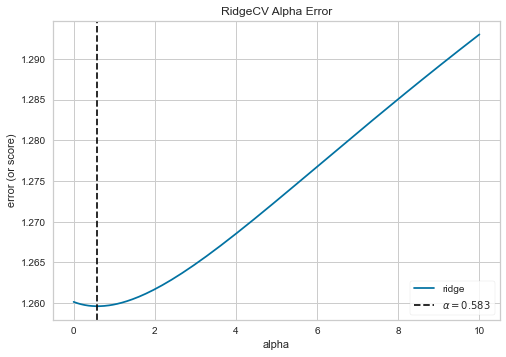

In [19]:
alphas = np.logspace(-10, 1, 500)    # alphaの探索空間 = [10**(-10), 10**1]
#↑ 10^-10～10^1を500分割したもの
RIDGE_CV = RidgeCV(alphas=alphas)
visualizer = AlphaSelection(RIDGE_CV)
visualizer.fit(X_train, y_train)
visualizer.show()
plt.show()

### Ridge回帰係数の変化

Ridge正則化ハイパーパラメータ$\alpha$が大きくなるにつれて、各入力変数の回帰係数がどのように変化するか観察しましょう。

In [20]:
alphas = np.logspace(-10, 10, 500)
coefs = []
for alpha in alphas:
    RIDGE = Ridge(alpha = alpha)
    RIDGE.fit(X_train, y_train)
    coefs.append(RIDGE.coef_)

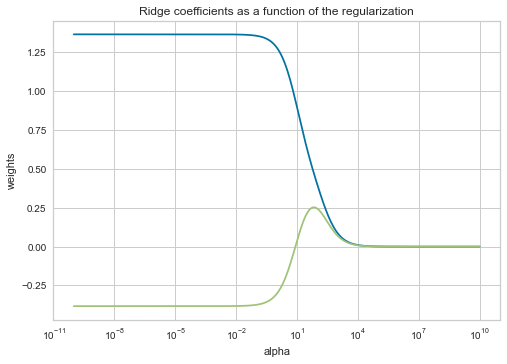

In [21]:
# 横軸 : alpha, 縦軸 : Ridge coefficient
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Ridge coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

**演習** 正則化にはRidge回帰モデル以外にも、Lasso回帰モデルが知られています。Lasso回帰モデルは罰則に
$$||w||=|w_0|+|w_1|+\cdots+|w_d|$$
を用いる回帰モデルです。
1. model A：$f(x) = 1 + 2x$, model B：$g(x) = 3x$でLasso回帰では受ける罰則の大きさは同じであることを説明してください。
2. Lasso回帰はRidge回帰と同様、`sklearn.linear_model`モジュールの`Lasso`クラスとして実装されています。Ridge回帰の場合のスクリプトを書き換えて、線形回帰モデルにおける多重共線性の例の場合にLasso回帰を実装してみてください。
3. Lasso正則化ハイパーパラメータの変化に応じてLasso回帰係数がどのように変化するかをプロットし、Ridge回帰と比較してLasso回帰がどのような特徴を持つか述べてください。

**解答**

* 1の解答：model Aもmodel Bも$||w||=3$なので罰則は等しい。

In [22]:
# 2の解答, 上と同じデータを用いる。
# Lassoのインスタンスを建てて、学習させる。
LASSO = Lasso(alpha = 0.01)    # インスタンスを建てる。
LASSO.fit(X_train, y_train)    # fitメソッド：学習させる。
LASSO.intercept_, LASSO.coef_

(0.39369367766817515, array([ 1.26188457, -0.27950495]))

* 3の解答：Lasso回帰はRidge回帰に比べ、回帰係数を厳密に0にする性質があります。これを**スパース性**といいます。

In [23]:
alphas = np.logspace(-10, 10, 500)
coefs = []
for alpha in alphas:
    LASSO = Lasso(alpha = alpha)
    LASSO.fit(X_train, y_train)
    coefs.append(LASSO.coef_)

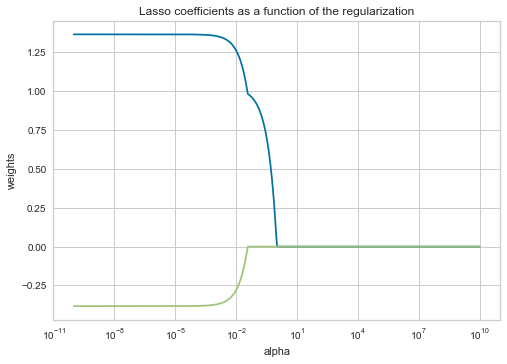

In [24]:
# 横軸 : alpha, 縦軸 : LASSO coefficient
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale("log")
plt.xlabel("alpha")
plt.ylabel("weights")
plt.title("Lasso coefficients as a function of the regularization")
plt.axis("tight")
plt.show()

#### B3. 正則化における留意点
正則化を用いる場合、**入力を標準化して用いた方が良いかもしれない**ということは念頭においておくと良いでしょう。

Ridge回帰やLasso回帰のように正則化項がパラメータの重みの大きさによって定義されている場合、例えば変数を100倍でレコードしなおすとパラメータは0.01倍になることが期待されるので、それだけ正則化の影響を受けなくなるといった現象が起こります。このような理由から、なんらかの方法で入力変数を標準化してから正則化を行うことが一般的です。